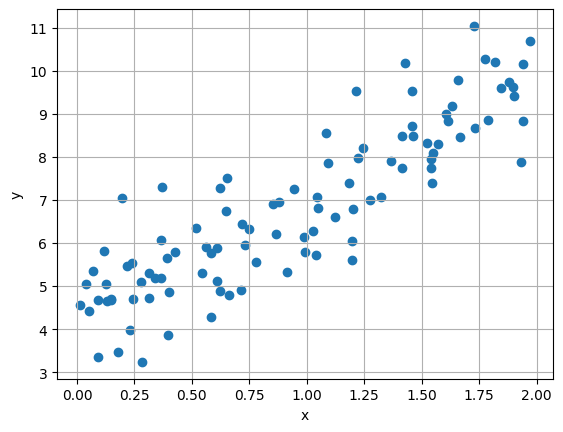

In [141]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)  # to make this code example reproducible
m = 100  # number of instances
x = 2 * np.random.rand(m, 1)  # column vector
y = 4 + 3 * x + np.random.randn(m, 1)  # column vector

plt.scatter(x, y)

plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.savefig("noisy_line_plot.png")

In [142]:
import numpy as np

mu_x = x.sum() / m
mu_y = y.sum() / m

theta_1 = (mu_y * x.sum() - (y * x).sum()) / (mu_x * x.sum() - (x * x).sum())
theta_0 = mu_y - theta_1 * mu_x
print(theta_0, theta_1)

4.2150961575467445 2.770113386438486


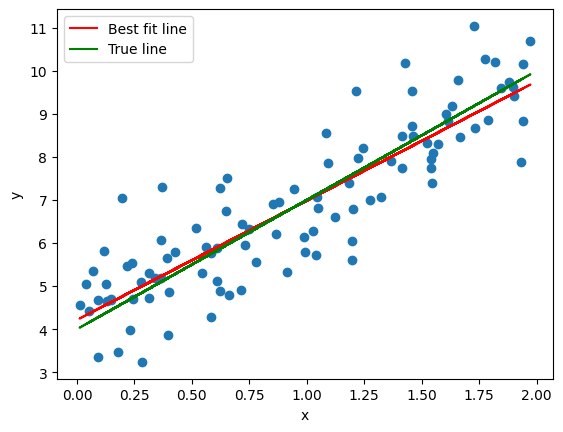

In [143]:
plt.scatter(x, y)
plt.plot(x, theta_0 + theta_1 * x, "r-", label="Best fit line")
plt.plot(x, 4 + 3 * x, "g-", label="True line")

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.savefig("best_fit_line.png")

In [145]:
# Matrix implementation
X = np.hstack([np.ones((m, 1)), x])  # add x0 = 1 to each instance

theta_best = np.linalg.inv(X.T @ X) @ X.T @ y
print(theta_best)

[[4.21509616]
 [2.77011339]]


In [98]:
# Gradient Descent: Batch version
np.random.seed(42)
def gradient(X, y, theta):
    return 2 / X.shape[0] * X.T @ (X @ theta - y)

eta = 0.1  # learning rate
n_iterations = 100
theta_batch = np.zeros((n_iterations, 2))
theta = np.random.randn(2, 1)  # random initialization

for i in range(n_iterations):
    theta = theta - eta * gradient(X, y, theta)
    theta_batch[i] = theta.T

batch_best = theta

In [99]:
# Stochastic Gradient Descent
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1)  # random initialization
theta_sgd = np.zeros((n_epochs * m, 2))

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X[random_index : random_index + 1]
        yi = y[random_index : random_index + 1]
        gradients = gradient(xi, yi, theta)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_sgd[epoch * m + i] = theta.T

sgd_best = theta

In [129]:
# Mini-batch Gradient Descent

n_epochs = 50
minibatch_size = 20
n_batches_per_epoch = m // minibatch_size

np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization
theta_mgd = np.zeros((n_epochs * n_batches_per_epoch, 2))

for epoch in range(n_epochs):
    shuffled_indices = np.random.permutation(m)
    X_shuffled = X[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(n_batches_per_epoch):
        xi = X_shuffled[i * minibatch_size : (i + 1) * minibatch_size]
        yi = y_shuffled[i * minibatch_size : (i + 1) * minibatch_size]
        gradients = gradient(xi, yi, theta)
        eta = learning_schedule(epoch * n_batches_per_epoch + i)
        theta = theta - eta * gradients
        theta_mgd[epoch * n_batches_per_epoch + i] = theta.T

mgd_best = theta


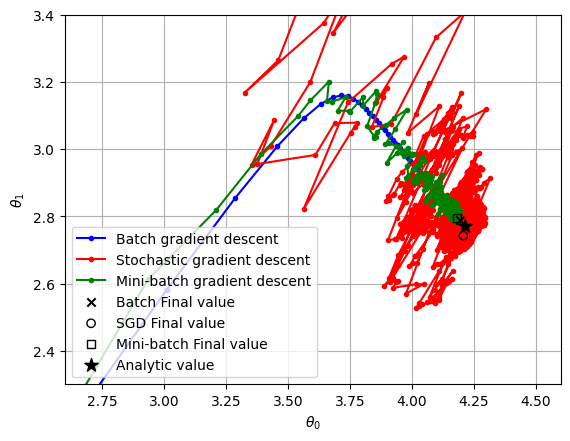

In [133]:
plt.plot(theta_batch[:, 0], theta_batch[:, 1], "b.-", label="Batch gradient descent")
plt.plot(theta_sgd[:, 0], theta_sgd[:, 1], "r.-", label="Stochastic gradient descent")
plt.plot(theta_mgd[:, 0], theta_mgd[:, 1], "g.-", label="Mini-batch gradient descent")
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
plt.scatter(batch_best[0], batch_best[1], color='k', marker='x', label='Batch Final value', zorder=10)
plt.scatter(sgd_best[0], sgd_best[1], edgecolors='k', facecolors='none', marker='o', label='SGD Final value', zorder=10)
plt.scatter(mgd_best[0], mgd_best[1], edgecolors='k', facecolors='none', marker='s', label='Mini-batch Final value', zorder=10)
plt.scatter(theta_best[0], theta_best[1], color='k', marker='*', label='Analytic value', zorder=10, s=100)
plt.legend()
plt.grid(True)
plt.axis([2.6, 4.6, 2.3, 3.4])
plt.savefig("gradient_descent_comparison.png")

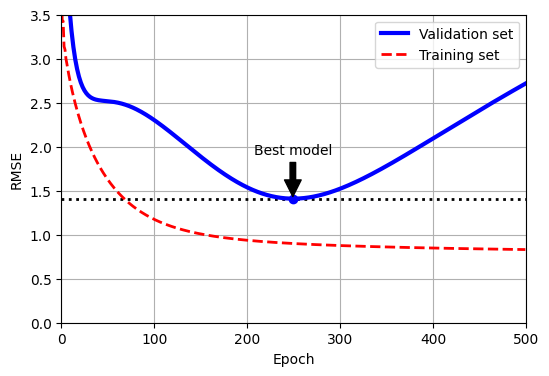

In [139]:
# Illustration of early stopping
from copy import deepcopy
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor

# extra code – creates the same quadratic dataset as earlier and splits it
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)
X_train, y_train = X[: m // 2], y[: m // 2, 0]
X_valid, y_valid = X[m // 2 :], y[m // 2 :, 0]

preprocessing =Pipeline([
    ("Poly Features", PolynomialFeatures(degree=90, include_bias=False)),
     ("Scaler", StandardScaler())
     ])


X_train_prep = preprocessing.fit_transform(X_train)
X_valid_prep = preprocessing.transform(X_valid)
sgd_reg = SGDRegressor(penalty=None, eta0=0.002, random_state=42)
n_epochs = 500
best_valid_rmse = float('inf')
train_errors, val_errors = [], []  # extra code – it's for the figure below

for epoch in range(n_epochs):
    sgd_reg.partial_fit(X_train_prep, y_train)
    y_valid_predict = sgd_reg.predict(X_valid_prep)
    val_error = mean_squared_error(y_valid, y_valid_predict, squared=False)
    if val_error < best_valid_rmse:
        best_valid_rmse = val_error
        best_model = deepcopy(sgd_reg)

    # extra code – we evaluate the train error and save it for the figure
    y_train_predict = sgd_reg.predict(X_train_prep)
    train_error = mean_squared_error(y_train, y_train_predict, squared=False)
    val_errors.append(val_error)
    train_errors.append(train_error)

# extra code – this section generates and saves Figure 4–20
best_epoch = np.argmin(val_errors)
plt.figure(figsize=(6, 4))
plt.annotate('Best model',
             xy=(best_epoch, best_valid_rmse),
             xytext=(best_epoch, best_valid_rmse + 0.5),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.plot([0, n_epochs], [best_valid_rmse, best_valid_rmse], "k:", linewidth=2)
plt.plot(val_errors, "b-", linewidth=3, label="Validation set")
plt.plot(best_epoch, best_valid_rmse, "bo")
plt.plot(train_errors, "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.axis([0, n_epochs, 0, 3.5])
plt.grid()

plt.savefig("early_stopping.png")